@author Nassir, Mohammad

## Imports

In [1]:
import sys 
sys.path.append('../scripts')
sys.path.append('../')

from perception import Perception
from utilities import show_results
from utilities import plot_data

from scipy.io import loadmat
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from pyod.models.mcd import MCD

import seaborn as sns
import matplotlib.pyplot as plt

image_save_switch = False
image_save_path = ''

## Example 1: hypothetical dataset for outlier detection 

This example illustrates anomaly detection on a hypothetical small dataset
taken from: Boris Iglewicz and David C. Hoaglin. How to Detect and Handle
Outliers, ASQC basic references in quality control, ASQC Quality Press,
1993. The example illustrates the failure of the Z-score methods.

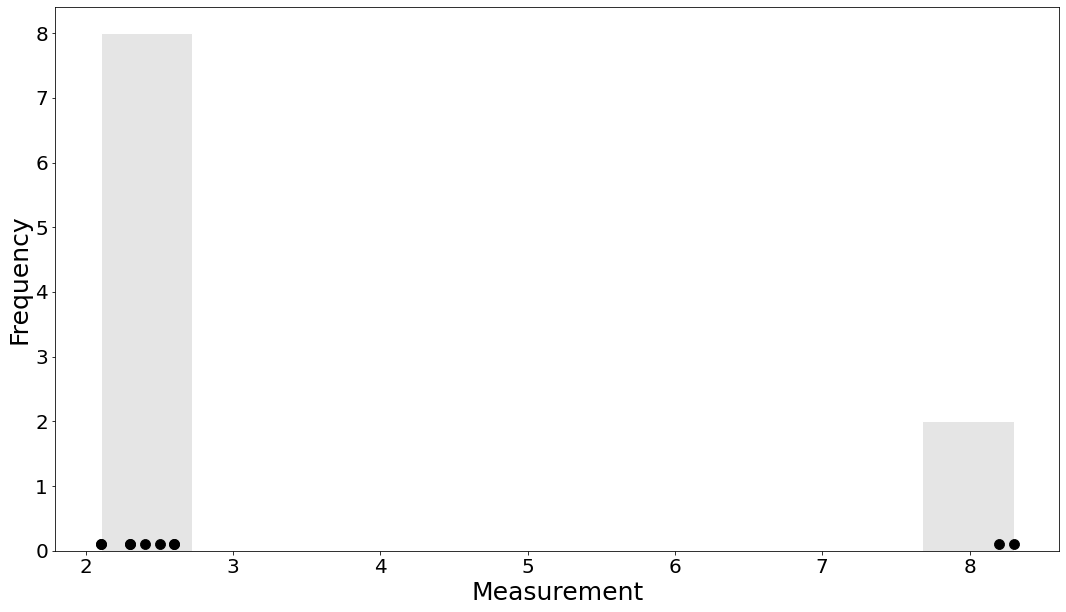

In [2]:
data = np.array([2.1, 2.6, 2.4, 2.5, 2.3, 2.1, 2.3, 2.6, 8.2, 8.3])
save_path = image_save_path + 'BorisHypo1.png'
plot_data(data, save_path, save_switch=image_save_switch, x_label='Measurement', y_label='Frequency')

In [3]:
# run anomaly detection

clf = Perception()
clf.fit(data)
clf.predict(data)

# print anomalies by position: 0 is normal, 1 is anomalous
print("anomaly labels: {}".format(clf.labels_))

# print associated anomaly scores: all scores > 0 are anomalous. 
# The greater the score, the more anomalous is the observation.
print("anomaly scores: {}".format(clf.scores_))

# print the anomaly values
print("anomalies: {}".format(clf.anomalies_))

anomaly labels: [0 0 0 0 0 0 0 0 1 1]
anomaly scores: [-0.07435932 -0.06177481 -0.01771219 -0.04510522 -0.04510522 -0.07435932
 -0.04510522 -0.06177481  0.3222579   0.33842644]
anomalies: [8.2 8.3]


## Example 2: Galton heights

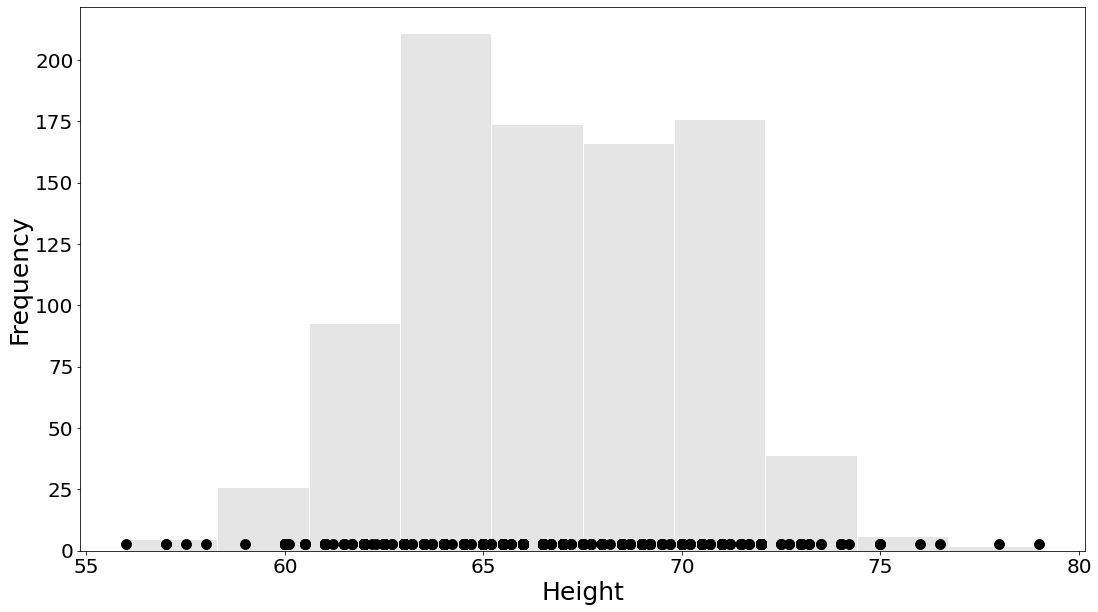

In [4]:
galton_height_path = "../data/Galton.txt"
g_df = pd.read_csv(galton_height_path, sep='\t', lineterminator='\r')

data = g_df['Height'].values

save_path = image_save_path + 'galton_heights.png'
plot_data(data, save_path, save_switch=image_save_switch, balls_height=2.8,
          x_label='Height', y_label='Frequency')

In [5]:
# run anomaly detection

clf = Perception()
clf.fit(data)
clf.predict(data)

# print anomalies by position: 0 is normal, 1 is anomalous
#print("anomaly labels: {}".format(clf.labels_))

# print associated anomaly scores: all scores > 0 are anomalous. 
# The greater the score, the more anomalous is the observation.
#print("anomaly scores: {}".format(clf.scores_))

# print the unique anomaly values
print("anomalies: {}".format(np.unique(clf.anomalies_)))

anomalies: [56.  57.  57.5 76.  76.5 78.  79. ]


## Example 3: ex8data1 (2-dimensional data) 

From: Andrew Ng. Machine learning: Programming Exercise 8: Anomaly Detection and Recommender Systems. 2012.

In [6]:
data_path = r"../data/ex8data1.mat"
data = loadmat(data_path)
X = data['X']
X_val = data['Xval']
y_val = data['yval']

# show the headers
for key, val in data.items():
    print(key)

print("The shape of X is: {}".format(X.shape))
print("The shape of X_val is: {}".format(X_val.shape))
print("The shape of y is: {}".format(y_val.sum()))

__header__
__version__
__globals__
X
Xval
yval
The shape of X is: (307, 2)
The shape of X_val is: (307, 2)
The shape of y is: 9


In [7]:
# %% Standarise the validation data only (training data not used)
sc = StandardScaler()
sc.fit(X_val)
X_val = sc.transform(X_val)

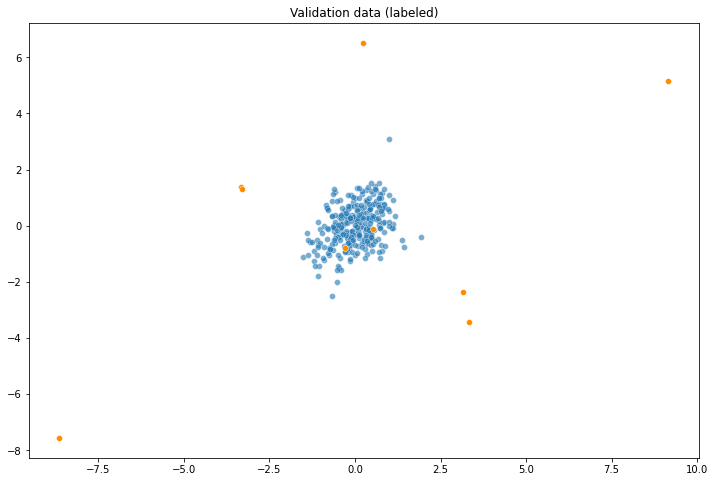

In [8]:
# %% plot the labelled validation data
X_val_anomalies = X_val[np.where(y_val == 1)[0]]
X_val_normal = X_val[np.where(y_val == 0)[0]]

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.scatterplot(x=X_val_normal[:, 0], y=X_val_normal[:, 1], alpha=0.6)
ax = sns.scatterplot(x=X_val_anomalies[:, 0], y=X_val_anomalies[:, 1],
                     color='darkorange', alpha=1)
ax.set_title("Validation data (labeled)");

### MCD (elliptic envelope) algorithm

              precision    recall  f1-score   support

      normal       0.99      0.92      0.95       298
    abnormal       0.23      0.78      0.35         9

    accuracy                           0.92       307
   macro avg       0.61      0.85      0.65       307
weighted avg       0.97      0.92      0.94       307

auc score: 0.8758389261744967


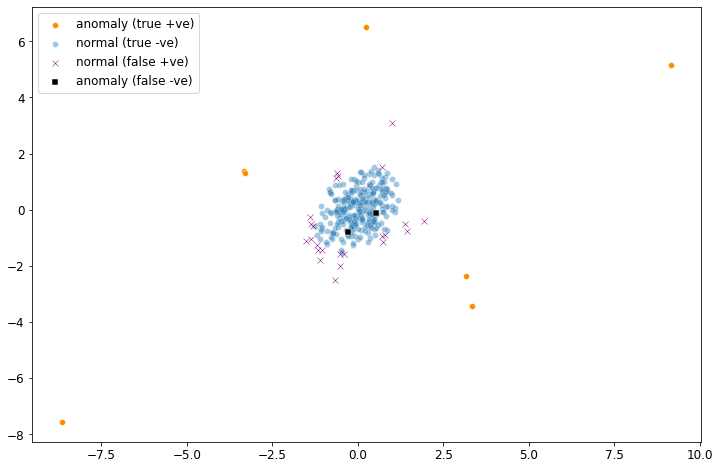

In [9]:
# apply MCD anomaly detector and show results
clf_mcd = MCD()
clf_mcd.fit(X_val)
validation_labels = clf_mcd.predict(X_val)
scores = clf_mcd.decision_function(X_val)

show_results(X_val, y_val, validation_labels,
             font_size="12",
             file_to_save=image_save_path + 'ex8data1_validation_mcd.png',
             figure_title='',  # "MCD results (validation data only)",
             decision_scores=scores,
             save_switch=image_save_switch)

### Perception algorithm

              precision    recall  f1-score   support

      normal       0.99      0.99      0.99       298
    abnormal       0.64      0.78      0.70         9

    accuracy                           0.98       307
   macro avg       0.81      0.88      0.84       307
weighted avg       0.98      0.98      0.98       307

auc score: 0.9343773303504848


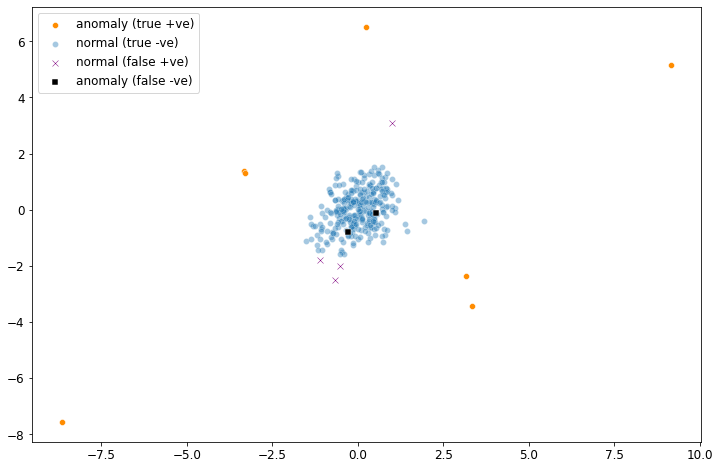

In [10]:
clf_perception = Perception()
clf_perception.fit(X_val)
validation_labels = clf_perception.predict(X_val)

show_results(X_val, y_val, validation_labels,
             font_size="12",
             file_to_save=image_save_path+'ex8data1_validation_perception.png',
             figure_title='',  # "Perception results (validation data only)",
             decision_scores=clf_perception.scores_,
             save_switch=image_save_switch)

## Example 4: ex8data2 (Multidimensional data)

From: Andrew Ng. Machine learning: Programming Exercise 8: Anomaly Detection and Recommender Systems. 2012.

In [11]:
data_path = r"../data/ex8data2.mat"
data = loadmat(data_path)
X2 = data['X']
X2_val = data['Xval']
y2_val = data['yval']

# show the headers
for key, val in data.items():
    print(key)

print("The shape of X2 is: {}".format(X2.shape))
print("The shape of X2_val is: {}".format(X2_val.shape))
print("The shape of y2 is: {}".format(y2_val.sum()))

__header__
__version__
__globals__
X
Xval
yval
The shape of X2 is: (1000, 11)
The shape of X2_val is: (100, 11)
The shape of y2 is: 10


In [12]:
# standardise the data
sc = StandardScaler()
sc.fit(X2)
X2 = sc.transform(X2)
X2_val = sc.transform(X2_val)

In [13]:
clf_perception = Perception()
clf_perception.fit(X2)
clf_perception.predict(X2_val)

validation_labels = clf_perception.labels_

print(classification_report(
    y2_val, validation_labels,
    target_names=['normal', 'abnormal'], output_dict=False))

auc_score = roc_auc_score(y2_val, clf_perception.scores_)
print('auc score: {}'.format(auc_score))

              precision    recall  f1-score   support

      normal       0.96      0.98      0.97        90
    abnormal       0.75      0.60      0.67        10

    accuracy                           0.94       100
   macro avg       0.85      0.79      0.82       100
weighted avg       0.94      0.94      0.94       100

auc score: 0.8588888888888889
